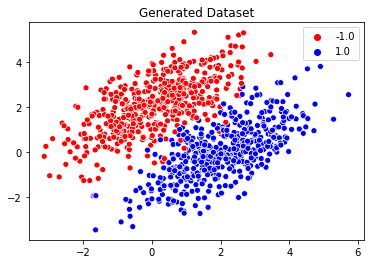

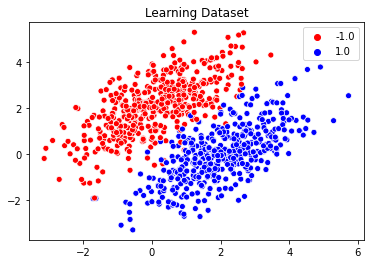

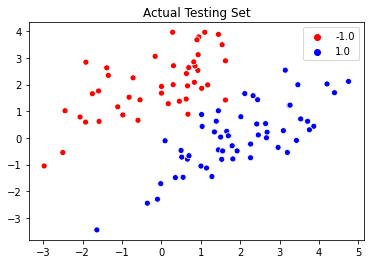

     pcost       dcost       gap    pres   dres
 0: -9.6478e+02 -5.9702e+04  2e+05  8e-01  3e-13
 1: -5.7154e+02 -1.5002e+04  2e+04  7e-02  3e-13
 2: -3.5011e+02 -2.7637e+03  3e+03  1e-02  2e-13
 3: -3.8555e+02 -1.1907e+03  1e+03  2e-03  2e-13
 4: -4.1371e+02 -1.0545e+03  7e+02  2e-03  2e-13
 5: -4.3406e+02 -9.1809e+02  5e+02  1e-03  2e-13
 6: -4.5365e+02 -8.3508e+02  4e+02  7e-04  2e-13
 7: -4.6945e+02 -7.2578e+02  3e+02  2e-04  2e-13
 8: -4.8598e+02 -6.9273e+02  2e+02  1e-04  2e-13
 9: -5.0194e+02 -6.5861e+02  2e+02  1e-04  2e-13
10: -5.1197e+02 -6.3136e+02  1e+02  6e-05  2e-13
11: -5.1574e+02 -6.1007e+02  1e+02  2e-05  2e-13
12: -5.2093e+02 -5.9974e+02  8e+01  2e-05  2e-13
13: -5.3364e+02 -5.7619e+02  4e+01  7e-06  2e-13
14: -5.3312e+02 -5.7368e+02  4e+01  5e-06  2e-13
15: -5.3391e+02 -5.7244e+02  4e+01  4e-06  2e-13
16: -5.4428e+02 -5.5827e+02  1e+01  7e-07  2e-13
17: -5.4992e+02 -5.5132e+02  1e+00  2e-08  3e-13
18: -5.5032e+02 -5.5086e+02  5e-01  7e-09  2e-13
19: -5.5039e+02 -5.50

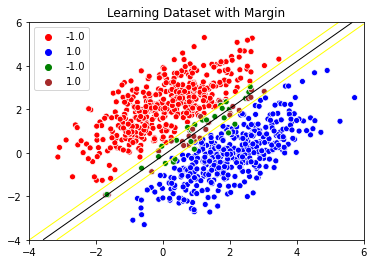

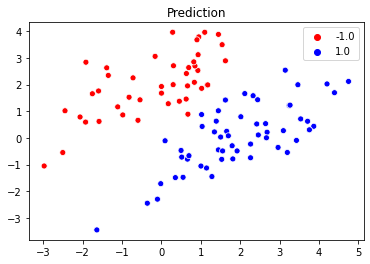

Error in prediction : 1.0%


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import math
import seaborn as sbn
import copy
import random as rnd
import cvxopt
from sklearn.model_selection import train_test_split

def generatedataset(size,mean1,cov1,mean2,cov2): 
  np.random.seed(0) 
  n = int(size/2)
  Y1 = np.ones(n)*-1.0
  X1 = np.random.multivariate_normal(mean1,cov1,size=n)
  D1 = np.c_[X1,Y1]
  Y2 = np.ones(n)
  X2 = np.random.multivariate_normal(mean2,cov2,size=n)
  D2 = np.c_[X2,Y2]
  dataset = np.concatenate((D1,D2),axis=0)
  np.random.shuffle(dataset)
  return dataset

def Error(testset,lst):
  c = 0
  n = len(lst)
  for i in range(n):
    if testset[i][2] != lst[i]:
      c = c+1
  return c*100/n;

def SoftMlinearSVM(learnset,C):
  n = len(learnset)
  X = learnset[:,:-1]
  y = learnset[:,-1]
  K = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      K[i,j] = np.dot(X[i],X[j])
  P = cvxopt.matrix(np.outer(y,y) * K)
  q = cvxopt.matrix(np.ones(n) * -1)
  A = cvxopt.matrix(y, (1,n))
  b = cvxopt.matrix(0.0)
  tmp1 = cvxopt.matrix(np.diag(np.ones(n) * -1))
  tmp2 = np.identity(n)
  G = cvxopt.matrix(np.vstack((tmp1,tmp2)))
  tmp1 = np.zeros(n)
  tmp2 = np.ones(n)*C
  h = cvxopt.matrix(np.hstack((tmp1,tmp2)))

  solution = cvxopt.solvers.qp(P, q, G, h, A, b)
  aa = np.ravel(solution['x'])
  sv = aa > 1e-5
  ind = np.arange(len(aa))[sv]
  a = aa[sv]
  SV = X[sv]
  SV_y = y[sv]
  print("%d support vectors out of %d points" % (len(a), n))

  b = 0
  for i in range(len(a)):
    b = b + SV_y[i]
    b = b - np.sum(a*SV_y*K[ind[i],sv])
  b = b/len(a)

  w = np.zeros(len(X[0]))
  for i in range(len(a)):
    w = w + a[i]*SV_y[i]*SV[i]
  return w,b,SV,SV_y

def predict(w,b,testset):
  data = testset[:,:-1]
  lbl = np.dot(data,w)+b
  sbn.scatterplot(data[:,0],data[:,1],hue = np.sign(lbl),palette = ['red','blue']).set_title('Prediction')
  plt.show()
  return np.sign(lbl)

def plotmargin(learnset,w,b,sv,sy):  
  sbn.scatterplot(learnset[:,0],learnset[:,1],hue = learnset[:,2],palette = ['red','blue'])#.set_title('Prediction')
  sbn.scatterplot(sv[:,0],sv[:,1],hue = sy,palette = ['green','brown']).set_title('Learning Dataset with Margin')
  X1, X2 = np.meshgrid(np.linspace(-4,6,50),np.linspace(-4,6,50))
  X = np.array([[x1, x2] for x1,x2 in zip(np.ravel(X1),np.ravel(X2))])
  #print(X)
  lb = np.dot(X,w)+b
  Z = lb.reshape(X1.shape)
  plt.contour(X1, X2, Z, [0.0], colors = 'k', linewidths = 1, origin = 'lower')
  plt.contour(X1, X2, Z+1, [0.0], colors = 'yellow', linewidths = 1, origin = 'lower')
  plt.contour(X1, X2, Z-1, [0.0], colors = 'yellow', linewidths = 1, origin = 'lower')
  plt.axis("tight")
  plt.show()

size = 1000
mean1 = [0,2]
mean2 = [2,0]
cov = [[1.5,1],[1,1.5]]
dataset = generatedataset(size,mean1,cov,mean2,cov)
sbn.scatterplot(dataset[:,0],dataset[:,1],hue = dataset[:,2],palette = ['red','blue']).set_title('Generated Dataset')
plt.show()

learnset,testset = train_test_split(dataset,test_size = 0.1, random_state=1)
sbn.scatterplot(learnset[:,0],learnset[:,1],hue = learnset[:,2],palette = ['red','blue']).set_title('Learning Dataset')
plt.show()
sbn.scatterplot(testset[:,0],testset[:,1],hue = testset[:,2],palette = ['red','blue']).set_title('Actual Testing Set')
plt.show()

C = 10
w,b,sv,sy = SoftMlinearSVM(learnset,C)
plotmargin(learnset,w,b,sv,sy)

lst = predict(w,b,testset)
print("Error in prediction : "+str(Error(testset,lst))+"%")